In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.stattools import medcouple
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# home brew utitilties
import resources.utility_functions as ut
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from IPython.display import Markdown as md
from IPython.display import Math, Latex

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

# name of the output folder:
name_of_project = 'threshold_values'

# the scale for pieces per meter and the column and chart label for the units
reporting_unit = 100
unit_label = 'p/100m'

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# get your data:
survey_data = pd.read_csv('resources/results_with_land_use_2015.csv')
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/dims_data.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# map water_name_slug to water_name
wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True).drop_duplicates()
wname_wname.set_index('water_name_slug', inplace=True)

# convenience function for doing land use correlations
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    return ax, corr, a_p

# index the code data
dfCodes.set_index("code", inplace=True)

# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation: includes spray foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/tampons, applicators"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)
dfCodes = sut.shorten_the_value(["G82", "description", "Expanded foams 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G81", "description", "Expanded foams .5cm - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G117", "description", "Expanded foams < 5mm"], dfCodes)
dfCodes = sut.shorten_the_value(["G75", "description", "Plastic/foamed polystyrene 0 - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G76", "description", "Plastic/foamed polystyrene 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G24", "description", "Plastic lid rings"], dfCodes)
dfCodes = sut.shorten_the_value(["G33", "description", "Lids for togo drinks plastic"], dfCodes)
dfCodes = sut.shorten_the_value(["G3", "description", "Plastic bags, carier bags"], dfCodes)
dfCodes = sut.shorten_the_value(["G204", "description", "Bricks, pipes not plastic"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

(threshhold)=
# Calculating baseline values

Similar to survey results in the marine environment beach-litter-data in Switzerland is highly variable. With values ranging from zero (two surveys in 2020 had a quantity of zero), to thousands of objects and fragments within 100m of river of lake shoreline. The _JRC Technical Report: A European threshold value_ {cite}`eubaselines` suggests several methods for calculating threshold values, confidence intervals and extreme values. Examples of the proposed methods are applied to the survey results from IQAASL.

__Assumptions:__

*  The more trash there is on the ground the more a person is likely to find
*  **The survey results represent the minimum amount of trash at that site**
*  For each survey: finding one item does not effect the chance of finding another

## The data

Only surveys with a length greater than ten meters and less than 100 meters are included in the baseline calculation. The available space to survey in urban or suburban environments is limited, changes in the lake level and wave action can have significant effects on the available space to survey, including reducing the length of available shoreline. In IQAASL the policy was to avoid doing surveys less than ten meters. Note that this does not exclude all surveys from a location, only those that were less than ten meters.

In [2]:
# define the final survey data set here:
a_data = survey_data.copy()

# make a loc_date column from the survey data
# before converting to timestamp
a_data['loc_date']=tuple(zip(a_data.location, a_data.date))

# convert string dates from .csv to timestamp
a_data['date']=pd.to_datetime(a_data['date'], format='%Y-%m-%d')

# slice by start- end date
a_data = a_data[(a_data.date >= start_date)&(a_data.date <= end_date)]

# combine lugano and maggiore
# if the river bassin name does not equal tresa leave it, else change it to ticino
a_data['river_bassin'] = a_data.river_bassin.where(a_data.river_bassin != 'tresa', 'ticino' )

# assign the reporting value
a_data[unit_label] = (a_data.pcs_m * reporting_unit).round(2)

# scale the streets to kilometers
a_data['streets'] = a_data.streets.astype('int')
a_data['streets km'] = a_data.streets/1000

# save the data before aggregating to test
before_agg = a_data.copy()

# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
some_foams = ['G81', 'G82', 'G83']

# the codes for the fragmented plastics
some_frag_plas = list(a_data[a_data.groupname == 'plastic pieces'].code.unique())

# this extracts and aggregates the members of the two code groups, returns a dataframe
the_plast_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_frag_plas,a_model_code="G79", a_new_code="Gfrags")
the_foam_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_foams, a_model_code="G82", a_new_code="Gfoam")

# the foam codes and fragmented plastic codes have been aggregated in to Gfrags and Gfoam
a_data = sut.replace_a_group_of_codes_with_one(a_data, new_code_values=[the_plast_rows, the_foam_rows], codes_to_replace=[*some_frag_plas, *some_foams])

# gather the dimensional data for the time frame from dfDims
# match records to survey data
fd_dims= dfDims[(dfDims.location.isin(a_data.location.unique()))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# make a loc_date column and get the unique values
fd_dims['loc_date'] = list(zip(fd_dims.location, fd_dims.date))

# map the survey area name to the dims data record
a_map = fd_dims[['loc_date', 'area']].set_index('loc_date')
l_map = fd_dims[['loc_date', 'length']].set_index('loc_date')

# map length and area from dims to survey data
for a_survey in fd_dims.loc_date.unique():
    a_data.loc[a_data.loc_date == a_survey, 'length'] = l_map.loc[[a_survey], 'length'][0]
    a_data.loc[a_data.loc_date == a_survey, 'area'] = a_map.loc[[a_survey], 'area'][0]

# exclude surveys less than 10 meters
gten_lhun = a_data.loc[(a_data.length > 10)].copy()

# this is a common aggregation
agg_pcs_quantity = {unit_label:'sum', 'quantity':'sum'}

# survey totals by location
dt_all = gten_lhun.groupby(['loc_date','location','river_bassin', 'water_name_slug','date'], as_index=False).agg(agg_pcs_quantity)

## Identifying extreme values

Extreme values are identified but not excluded from the baseline or confidence level calculations. The identification of extreme values is to ensure that extreme data are verified on a case by case basis and to apply the median for calculating baseline statistics. {cite}`eubaselines`

The occurrence of extreme values can influence the average of the data and the interpretation of survey results. According the to the JRC report:

>  The methodology for the identification of extreme values can be either expert judgement, or be based on statistical and modelling approaches, such as the application of Tukey’s box plots to detect potential outliers. For skewed distributions, the adjusted box plot is more appropriate. {cite}`eubaselines`

### Adjusted boxplots

Tukey’s boxplot is used to visualize the distribution of a univariate data set. The samples that fall within the first quartile ($Q_1$) and the third quartile ($Q_3$) are considered to be within the innerquartial range (IQR) = $Q_3 - Q_1$. Points out side of the inner quartile range are considered outliers if their value is greater or less than one of two limits:

* lower limit = $Q_1 - (1.5*IQR)$

* upper limit = $Q_3 + (1.5*IQR)$

Adusting the boxplot involves replacing the constant 1.5 with another parameter. This parameter is calculated using a method called the _medcouple_ (MC) and applying the result of that method to the constant 1.5. {cite}`adjbox` {cite}`medcouple` The new calculation looks like this:

* lower limit = $Q_1 - (1.5e^{-4MC}*IQR)$

* upper limit = $Q_3 + (1.5e^{3MC}*IQR)$

*The limit at which a survey is conisdered _extreme_ extends to the 98th percentile when the boxplots are adjusted as opposed to the 90th percentile if the constant is left at 1.5.*

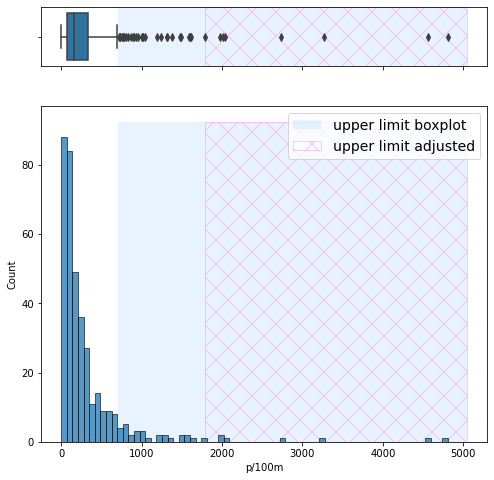

In [3]:
# implementation of medcouple
a_whis = medcouple(dt_all[unit_label].to_numpy())

# get the ecdf 
ecdf = ECDF(dt_all[unit_label].to_numpy())

# quantiles and IQR of the data
q1 = dt_all[unit_label].quantile(0.25)
q3 =dt_all[unit_label].quantile(0.75)
iqr = q3 - q1

# the upper and lower limit of extreme values unadjusted:
limit_lower = q1 - 1.5*iqr
limit_upper = q3 + 1.5*iqr

# the upper and lower limit of extreme values adjusted:
a_fence = q1 - (1.5*(math.exp((-4*a_whis))))*iqr
a_2fence = q3 + (1.5*(math.exp((3*a_whis))))*iqr

# source = https://stackoverflow.com/questions/12127635/matplotlib-can-we-draw-a-histogram-and-a-box-plot-on-a-same-chart
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8,8))

# Add a graph in each part
sns.boxplot(x=dt_all[unit_label], ax=ax_box)
sns.histplot(x=dt_all[unit_label], ax=ax_hist)

# get the limits of the x and y axix
xamax = ax_hist.get_xlim()
y_max= ax_hist.get_ylim()

# no xlabel on the top axis
ax_box.set_xlabel(" ")

# fill the areas concerened by each limt
ax_hist.fill_between(x=[limit_upper,xamax[1]], y1=y_max[1], label='upper limit boxplot', alpha=0.1, color="dodgerblue", linewidth=0.1)
ax_hist.fill_between(x=[a_2fence,xamax[1]], y1=y_max[1],label='upper limit adjusted', hatch='x', edgecolor='magenta', facecolor='none',alpha=0.2)

ax_box.fill_between(x=[limit_upper,xamax[1]], y1=ax_box.get_ylim()[1], y2=ax_box.get_ylim()[0],  label='upper limit boxplot', alpha=0.1, color="dodgerblue", linewidth=0.1)
ax_box.fill_between(x=[a_2fence,xamax[1]], y1=ax_box.get_ylim()[1], y2=ax_box.get_ylim()[0], label='upper limit adjusted', hatch='x', edgecolor='magenta', facecolor='none',alpha=0.2)

# get legend
handles, labels = ax_box.get_legend_handles_labels()
plt.legend(handles, labels, fontsize=14)

plt.show()

In [4]:
caption = F"""
*The diffrence between adjusted and normal boxplots. Adjusted = {int(a_2fence)} {unit_label},  unadjusted = {int(limit_upper)} {unit_label}.*
"""
md(caption)


*The diffrence between adjusted and normal boxplots. Adjusted = 1792 p/100m,  unadjusted = 708 p/100m.*


### Modeling

Extreme values can be indentified by assuming the data belong to some underlying known statistical distribution. Count data is often modeled using a poisson distribution, however this is only valid where variance is equal to the mean. The data from IQAASL and beach-litter data in general do not meet this criteria, the negative binomial (NB) distribution allows for the variance to be greater than the mean. {cite}`cameron` {cite}`wolfram`

> The modelling approach for the identification of extreme values is then performed by fitting the NB-distribution to the data by means of maximum likelihood and tagging all values in the right tail as potentially extreme values if the probability that they belong to the fitted NB-distribution is less than, e.g. 0.001. {cite}`threshholdeu`

#### NB method of moments

Modeling data is a vast domain and many fields and industries have developed specific algorythms using parameters from known relationships. The techniques from the MSFD are for greater temporal and spatial ranges than those defined by the IQAASL. The purpose of modeling for this example is to simply identify probable extreme values of aggregated data, a generalist approach by definition.

Fitting the NB distribution has all to do with estimating parameters, _maximum likelihood estimation_ can be an involved process. The method of moments produces comparable results and the parameters can be taken from the data {cite}`mlenb` {cite}`nbinom` {cite}`examplemmoments`.  The ratio of distributed objects to contributed objects is used to parametrize the distribution, see _Asessing transport_ for details. There are several basic statistical packages that cover this use, the examples here and elsewhere in this publication come from SciPy and statsmodels. {cite}`2020SciPy` {cite}`medcouple` 

*Estimating the parameters of the underlying NB distribution using the mean and the variance from the observed values* 

*implementation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html*

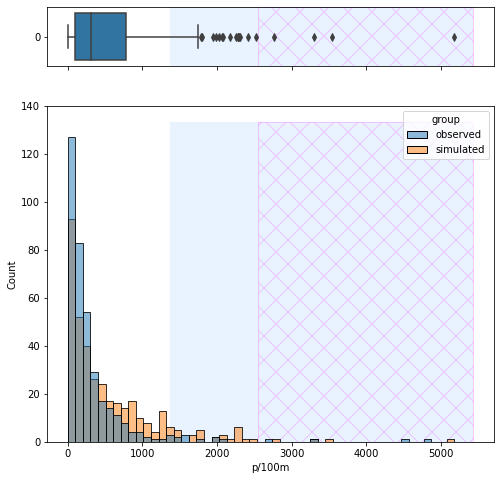

In [5]:
# the data to model
vals = dt_all[unit_label].to_numpy()

# whiskers for the boxplots
a_whis = medcouple(vals)

# the ratio of distributed items to contributed items in rural locations:
# see the assessing transport notebook for a complete epxlanation
dispersion_param = 1.7

# the variance
var = np.var(vals)

# the average
mean = np.mean(vals)

# dispersion
p = (mean/var)
n = (mean**2/(var-mean))*dispersion_param

# point estimates from for the 98 and 90 %ile
rv = stats.nbinom(n, p)
sim_98 = rv.ppf(.98)
obs_98 = np.quantile(vals, .98)

sim_90 = rv.ppf(.9)
obs_90 = np.quantile(vals, .9)

# simulated data
r = stats.nbinom.rvs(n,p, size=len(vals))
a_whis = medcouple(r)

# quantiles and IQR of the data
q1 = np.percentile(r, 25)
q3 =np.percentile(r,75)
iqr = q3 - q1

# the upper and lower limit of extreme values unadjusted:
limit_lower = q1 - 1.5*iqr
limit_upper = q3 + 1.5*iqr

# the upper and lower limit of extreme values adjusted:
a_fence = q1 - (1.5*(math.exp((-4*a_whis))))*iqr
a_2fence = q3 + (1.5*(math.exp((3*a_whis))))*iqr

# format data for charting
df = pd.DataFrame({unit_label:vals, 'group':'observed'})
df = df.append(pd.DataFrame({unit_label:r, 'group':'simulated'}))

fig, (axone, axtwo) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8,8))

# Add a graph in each part
sns.boxplot(data=df[df.group == 'simulated'][unit_label], orient='h',ax=axone)
sns.histplot(data=df, x=unit_label, hue='group', stat='count', multiple="layer", legend=True, ax=axtwo)

# get the limits of the x and y axis
xamax = axtwo.get_xlim()
y_max= axtwo.get_ylim()

# no xlabel on the top axis
axone.set_xlabel(" ")

# fill the areas concerened by each limit
axtwo.fill_between(x=[sim_90,xamax[1]], y1=y_max[1], label='lower limit simulated', alpha=0.1, color="dodgerblue", linewidth=0.1)
axtwo.fill_between(x=[sim_98,xamax[1]], y1=y_max[1],label='upper limit simulated', hatch='x', edgecolor='magenta', facecolor='none',alpha=0.2)

axone.fill_between(x=[sim_90,xamax[1]], y1=axone.get_ylim()[1], y2=axone.get_ylim()[0],  label='upper limit boxplot', alpha=0.1, color="dodgerblue", linewidth=0.1)
axone.fill_between(x=[sim_98,xamax[1]], y1=axone.get_ylim()[1], y2=axone.get_ylim()[0], label='upper limit adjusted', hatch='x', edgecolor='magenta', facecolor='none',alpha=0.2)

plt.show()

In [6]:
caption = F"""
*Point estimate of the 98th percentile from simulated data = {int(sim_98)} {unit_label}, estimate of the 90th percentile = {int(sim_90)} {unit_label}*
"""
md(caption)


*Point estimate of the 98th percentile from simulated data = 2548 p/100m, estimate of the 90th percentile = 1366 p/100m*


### Confidence intervals

Confidence intervals (CIs) help approximate or mitigate the uncertainty of beach-litter survey results. Another way to mitigate uncertainty is to have the appropriate number of samples for the region or area of interest. In the marine environment the recomended minimum number of surveys for each region is 40 if calculating CIs, after that there is only a limited gain in the improvement of the CI.{cite}`eubaselines`

Even though the extreme values have been identified they are included in the data set for calcualting base lines and confidence intervals:

> It was agreed to leave the extreme data in the dataset, while highlighting the need to check to verify extreme data case by case and to apply the median for calculating of averages. This allows the use of all data while not skewing results through singleextraordinary high litter count surveys. {cite}`threshholdeu`


#### Bootstrap methods:

Bootstrapping is a resampling method that uses random sampling with replacement to repeat or simulate the sampling process. Bootstrapping permits the estimation of the sampling distribution of sample statistics using random sampling methods. {cite}`bootstrapdef` {cite}`bsci` {cite}`usingbootstrap` 

There are several computational methods to choose from such as percentile, BCa, and Student's t to name a few. For this example two methods were tested:

1. Percentile bootstrap
2. bias-corrected accelerated bootstrap confidence interval (BCa)

The _percentile method_ does not account for the _shape_ of the underlying distribution and this can lead to confidence intervals that do not match the data. The BCa corrects that. The implementation of these methods is straight forward using the previously cited packages. {cite}`bcatheory` {cite}`bcaimpdrysdale` {cite}`bcaconfidence`

In [7]:
# bootstrap percentile confidence intervals

# the number of reps
n=5000

# keep the observed values
observed_median = dt_all[unit_label].median()
observed_tenth = dt_all[unit_label].quantile(.15)

# place to keep the results from each resample

# for the median
sim_medians = []

# for the tenth percentile
sim_ten = []

# sample
for element in np.arange(n):    
    less = dt_all[unit_label].sample(n=len(dt_all), replace=True)    
    the_median = less.median()
    the_10th = less.quantile(.15)
    sim_medians.append(the_median)
    sim_ten.append(the_10th)

# get the upper and lower range of the sample median:
g_25 = np.percentile(sim_medians, 2.5)
g_975 = np.percentile(sim_medians, 97.5)

# get the upper and lower range of the tenth percentile:
g_25_ten = np.percentile(sim_ten, 2.5)
g_975_ten = np.percentile(sim_ten, 97.5)

caption = F"""
**Confidence intervals calculated using the percentile method**

95% confidence interval of the median survey total and the 10th percentile:

*CI of the median:  observed={round(observed_median, 2)} {unit_label}, lower limit={round(g_25, 2)} {unit_label}, upper limit={round(g_975, 2)} {unit_label}*

*CI of the 15th percentile:  observed={round(observed_tenth, 2)} {unit_label}, lower limit={round(g_25_ten, 2)} {unit_label}, upper limit={round(g_975_ten, 2)} {unit_label}*
"""
md(caption)


**Confidence intervals calculated using the percentile method**

95% confidence interval of the median survey total and the 10th percentile:

*CI of the median:  observed=158.0 p/100m, lower limit=139.0 p/100m, upper limit=194.0 p/100m*

*CI of the 15th percentile:  observed=45.5 p/100m, lower limit=39.0 p/100m, upper limit=53.0 p/100m*


In [8]:
# this code was modified from this source:
# http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/recitations/bootstrapping.html
# if you want to get the confidence interval around another point estimate use np.percentile
# and add the percentile value as a parameter

def draw_bs_sample(data):
    """Draw a bootstrap sample from a 1D data set."""
    return np.random.choice(data, size=len(data))

def compute_jackknife_reps(data, statfunction=None, stat_param=False):
    '''Returns jackknife resampled replicates for the given data and statistical function'''
    # Set up empty array to store jackknife replicates
    jack_reps = np.empty(len(data))

    # For each observation in the dataset, compute the statistical function on the sample
    # with that observation removed
    for i in range(len(data)):
        jack_sample = np.delete(data, i)
        if not stat_param:
            jack_reps[i] = statfunction(jack_sample)
        else:
            jack_reps[i] = statfunction(jack_sample, stat_param)          
        
    return jack_reps


def compute_a(jack_reps):
    '''Returns the acceleration constant a'''

    mean = np.mean(jack_reps)
    try:
        a = sum([(x**-(i+1)- (mean**-(i+1)))**3 for i,x in enumerate(jack_reps)])
        b = sum([(x**-(i+1)-mean-(i+1))**2 for i,x in enumerate(jack_reps)])
        c = 6*(b**(3/2))
        data = a/c
    except:
        print(mean)
    return data


def bootstrap_replicates(data, n_reps=1000, statfunction=None, stat_param=False):
    '''Computes n_reps number of bootstrap replicates for given data and statistical function'''
    boot_reps = np.empty(n_reps)
    for i in range(n_reps):
        if not stat_param:
            boot_reps[i] = statfunction(draw_bs_sample(data))
        else:
            boot_reps[i] = statfunction(draw_bs_sample(data), stat_param)     
        
    return boot_reps


def compute_z0(data, boot_reps, statfunction=None, stat_param=False):
    '''Computes z0 for given data and statistical function'''
    if not stat_param:
        s = statfunction(data)
    else:
        s = statfunction(data, stat_param)
    return stats.norm.ppf(np.sum(boot_reps < s) / len(boot_reps))


def compute_bca_ci(data, alpha_level, n_reps=1000, statfunction=None, stat_param=False):
    '''Returns BCa confidence interval for given data at given alpha level'''
    # Compute bootstrap and jackknife replicates
    boot_reps = bootstrap_replicates(data, n_reps, statfunction=statfunction, stat_param=stat_param)
    jack_reps = compute_jackknife_reps(data, statfunction=statfunction, stat_param=stat_param)

    # Compute a and z0
    a = compute_a(jack_reps)
    z0 = compute_z0(data, boot_reps, statfunction=statfunction, stat_param=stat_param)

    # Compute confidence interval indices
    alphas = np.array([alpha_level/2., 1-alpha_level/2.])
    zs = z0 + stats.norm.ppf(alphas).reshape(alphas.shape+(1,)*z0.ndim)
    avals = stats.norm.cdf(z0 + zs/(1-a*zs))
    ints = np.round((len(boot_reps)-1)*avals)
    ints = np.nan_to_num(ints).astype('int')

    # Compute confidence interval
    boot_reps = np.sort(boot_reps)
    ci_low = boot_reps[ints[0]]
    ci_high = boot_reps[ints[1]]
    return (ci_low, ci_high), a

upper_bca = compute_bca_ci(dt_all[unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.median)
lower_bca = compute_bca_ci(dt_all[unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=15)

caption = F"""
**Confidence intervals calcualted using BCa**

95% confidence interval of the median survey total and the 10th percentile:

*CI of the median:  observed={round(observed_median, 2)}, lower limit={round(upper_bca[0][0], 2)}, upper limit={round(upper_bca[0][1], 2)}*

*CI of the 15th percentile:  observed={round(observed_tenth, 2)}, lower limit={round(lower_bca[0][0], 2)}, upper limit={round(lower_bca[0][1], 2)}*
"""
md(caption)


**Confidence intervals calcualted using BCa**

95% confidence interval of the median survey total and the 10th percentile:

*CI of the median:  observed=158.0, lower limit=137.0, upper limit=188.0*

*CI of the 15th percentile:  observed=45.5, lower limit=39.0, upper limit=52.0*


### Discussion

The adoption of a standard measuring system and evaluation method is an important development. This allows for standardized analysis accross geographical regions and aggregation levels. Stakeholders now have an objective measurement and a method to measure.

* aggregate groups can ba analysed across regions

* one time events can be compared to regional baselines

This allows policy makers to measure the effects of current and past mitigation strategies. This report and the manner in which it was produced is one benefit of standardization.

#### Thresholds

The European Union has set a european wide threshold value of $\approx$ 20p/100m based on data collected in 2015-2016. This value is based on the $15^{th}$ percentile of the 2015-2016 results. In Switzerland the $15^{th}$ percentile is between 39 and 53 p/100m for 2020-2021.

### Number of samples

The recomended number of samples is by area of analysis. For an adequate analysis of a single body of water then the number of samples should be comensurate with the size and samples should be taken throughout the sampling period. However, individual results can be compared directly to baseline values for the region of interest. That is a direct benefit of using the median survey result.

#### Extreme values

The exact method to define an extreme value should be evaluated. In this article we used the EU methods because they are applicable for a larger geographic scale. Regional and municipal stakeholders most likely have specific knowledge that can explain extreme results much more efficiently than a model.

While modeling of the data and expected results is an interesting and challenging field it is NOT a prerequisite for defining extreme values. If there are enough samples then the extreme value can be set off the percentile rank of the current data set for the region of interest. Practically speaking this means that there should be enough samples and those samples need to be distributed geographically within a survey area such that individual surveys can be compared directly to the regional results.

This simplifies the assessment of individual surveys by local leaders. Thus empowering them to address the chalenges directly and in coordination with other stakeholders in the region.

#### Quality people = quality data

The quality of the data is directly related to the training and support of the surveyors. The identification process is long at first and many objects that are encountered are not part of an _average persons_ day. Encouraging meetings between surveyors and having a core team to assisst in the development and training ensures that the surveys are conducted consistently over time.

The surveyors are also responsible for data integrity and analysis of a survey area or multiple survey areas. This implies that the surveyors need to have or need to develop the skills required to gather, analyze and present the data using the standardized methods.

#### Objective criteria , analysis and communication

The data gathered during IQASL, SLR and the EU data from 2015-2016 are all compatible. This is because they were all based on the same protocol and that protocol **was designed to gather data as accurately as possible given limited resources and a large geographic area**. The same reasoning should apply to the analysis and communication of results. A consistent and objective analysis is the best communication tool. 

Municipalities and regional NGOS are usually well aware of the problem in general and have developed different communication methods. These results allow leaders to put the global problem in a local context within a previously defined communication strategy.

> There is a difference in urgency of action if you tell someone that a building 50km away is burining or the neighbors house is burning.

The importance of this is often overlooked and has repercussions with respect to resource allocation and prioritization of mitigation and attenuation strategies.

In [9]:
author = "roger@hammerdirt.ch"
my_message = "Love what you do. \u2764\ufe0f"
md(F"""
<br></br>
**This project was made possible by the Swiss federal office for the environment.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
""")


<br></br>
**This project was made possible by the Swiss federal office for the environment.**<br>

>Love what you do. ❤️<br>

*roger@hammerdirt.ch* pushed the run button on 2021-08-16.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
